# Pre-processing REFIT

In [1]:
import time
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

In [2]:
file_path = '' 
file = glob.glob(os.path.join(file_path, "*.csv"))  
file.sort()

In [3]:
def hourlyUnixTime(ucode):
    return int(ucode - ucode % 3600)
def unix2Date(ucode):
    time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(ucode))
    return time_str

In [4]:
def csv2HourlyAgg(csvName):
    df = pd.read_csv(csvName)
    df = df.iloc[:, [1, 2]]
    df.loc[:, 'HourlyUnix'] = df.Unix.apply(hourlyUnixTime)
    df = df.groupby('HourlyUnix',as_index=False).mean()[1:-1].reset_index(drop=True).drop(columns=['Unix'])
    return df
    #print(df.info())
    #plt.figure(figsize=(20,5))
    #plt.plot(df.Aggregate[240:600])

In [5]:
def firstStamp(csvName):
    df = pd.read_csv(csvName)
    df = df.iloc[:, [1, 2]]    
    df.loc[:, 'HourlyUnix'] = df.Unix.apply(hourlyUnixTime)
    df = df.groupby('HourlyUnix',as_index=False).mean()[1:-1].reset_index(drop=True).drop(columns=['Unix'])
    length = df.shape[0]
    return [df['HourlyUnix'][0], df['HourlyUnix'][length - 1]]

In [6]:
stp = firstStamp(file[1])

In [10]:
starts = []
ends = []
for f in file[1:]:
    stamps = firstStamp(f)
    starts.append(stamps[0])
    ends.append(stamps[1])

In [11]:
uStart = min(starts)

In [12]:
uEnd = max(ends)

Text(0.5, 1.0, 'Data Timespan (Unix Time Stamp)')

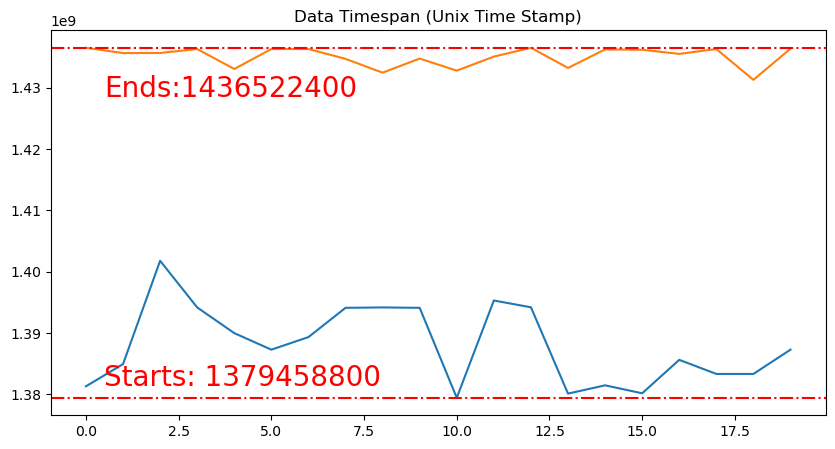

In [17]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(starts)
ax.axhline(y = min(starts), color = 'r', linestyle = '-.', )
ax.text(0.5, min(starts) + 2000000, f"Starts: {min(starts)}", color='r', fontsize=20)
plt.plot(ends)
ax.axhline(y = max(ends), color = 'r', linestyle = '-.', )
ax.text(0.5, max(ends) - 8000000, f"Ends:{ max(ends)}", color='r', fontsize=20)
plt.title('Data Timespan (Unix Time Stamp)')

In [91]:
def errHandler(readings):
    readings.loc[readings['Load'] > 4000, 'Load'] = None
    indexSpan = 15852
    
    error = False
    prev = 0
    count = 0
    for idx in range(indexSpan):
        if prev == readings.loc[idx, 'Load']:
            count += 1
        else:
            prev = readings.loc[idx, 'Load']
            count = 0
        if count > 2:
            readings.loc[idx, 'Load'] = None

def lowerBound(readings):
    return readings['Load'].min()

def hourlyRecord(readings):
    hr = []
    indexSpan = 15852
    
    for i in range(24): 
        hour = readings[readings.index % 24 == i]      
        hour.dropna(inplace=True)
        hour.reset_index(inplace=True)
        hour = hour.drop('index', axis=1)
        hr.append(hour)
    return hr

def hourlyAVG(hr):
    avgs = []
    
    for i in range(24):
        avgs.append(hr[i]['Load'].mean())
    return avgs

def randChoice(hr):
    
    return random.choice(hr)

def randVary(avg, rc, lb):
    pn = 0
    addition = avg
    
    if random.random() > 0.5:
        pn = 1
    else:
        pn = -1
    addition *= pn * random.random() * 0.5
    
    addition += rc
    
    if(addition < lb):
        if random.random() > 0.5:
            addition = lb + addition * 0.1
        else:
            addition = randVary(avg, rc, lb)
    
    return addition

def fillNA(readings):
    indexSpan = 15852
    hr = hourlyRecord(readings)
    avgs = hourlyAVG(hr)
    
    for i in range(24):
        for idx in range(i, indexSpan, 24):
            if pd.isnull(readings.loc[idx, 'Load']):
                readings.loc[idx, 'Load'] = randVary(avgs[i], randChoice(hr[i].Load), lowerBound(hr[i]))

def prePross(name, index):
    house = csv2HourlyAgg(name)
    house.set_index('HourlyUnix', inplace=True)
    merged = index.merge(house, how='outer', left_index=True, right_index=True)
    merged.reset_index(inplace=True)
    merged.rename(columns={'index': 'HourlyUnix'}, inplace=True)
    merged.rename(columns={'Aggregate': 'Load'}, inplace=True)
    errHandler(merged)
    fillNA(merged)
    merged.rename(columns={'Load': name}, inplace=True)
    return merged

def concat(district, building, name):
    merged = district.merge(building[name], how='outer', left_index=True, right_index=True)
    return merged

In [92]:
index = pd.DataFrame(index=range(1379458800, 1436522400 + 3600, 3600))
district = index.reset_index(inplace=False)
district.rename(columns={'index': 'HourlyUnix'}, inplace=True)
for house in file[1:]:
    building = prePross(house, index)
    district = concat(district, building, house)

C:\Users\wycon\anaconda3\envs\wyconDsrtdata\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


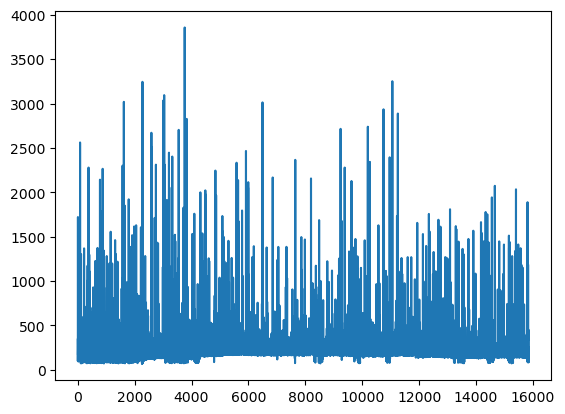

In [93]:
plt.plot(district['House_15.csv'])

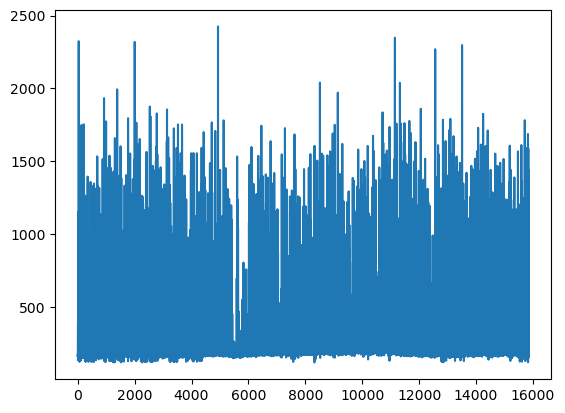

In [94]:
plt.plot(district['House_20.csv'])

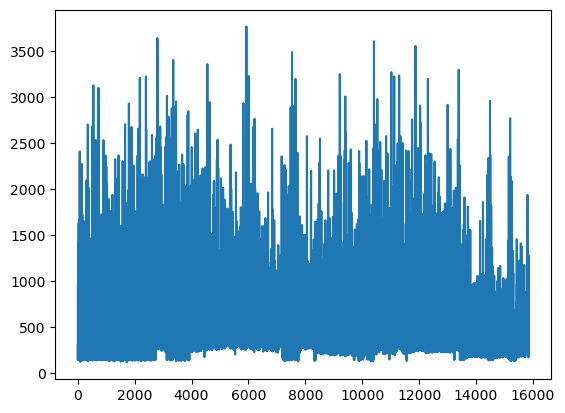

In [95]:
plt.plot(district['House_16.csv'])

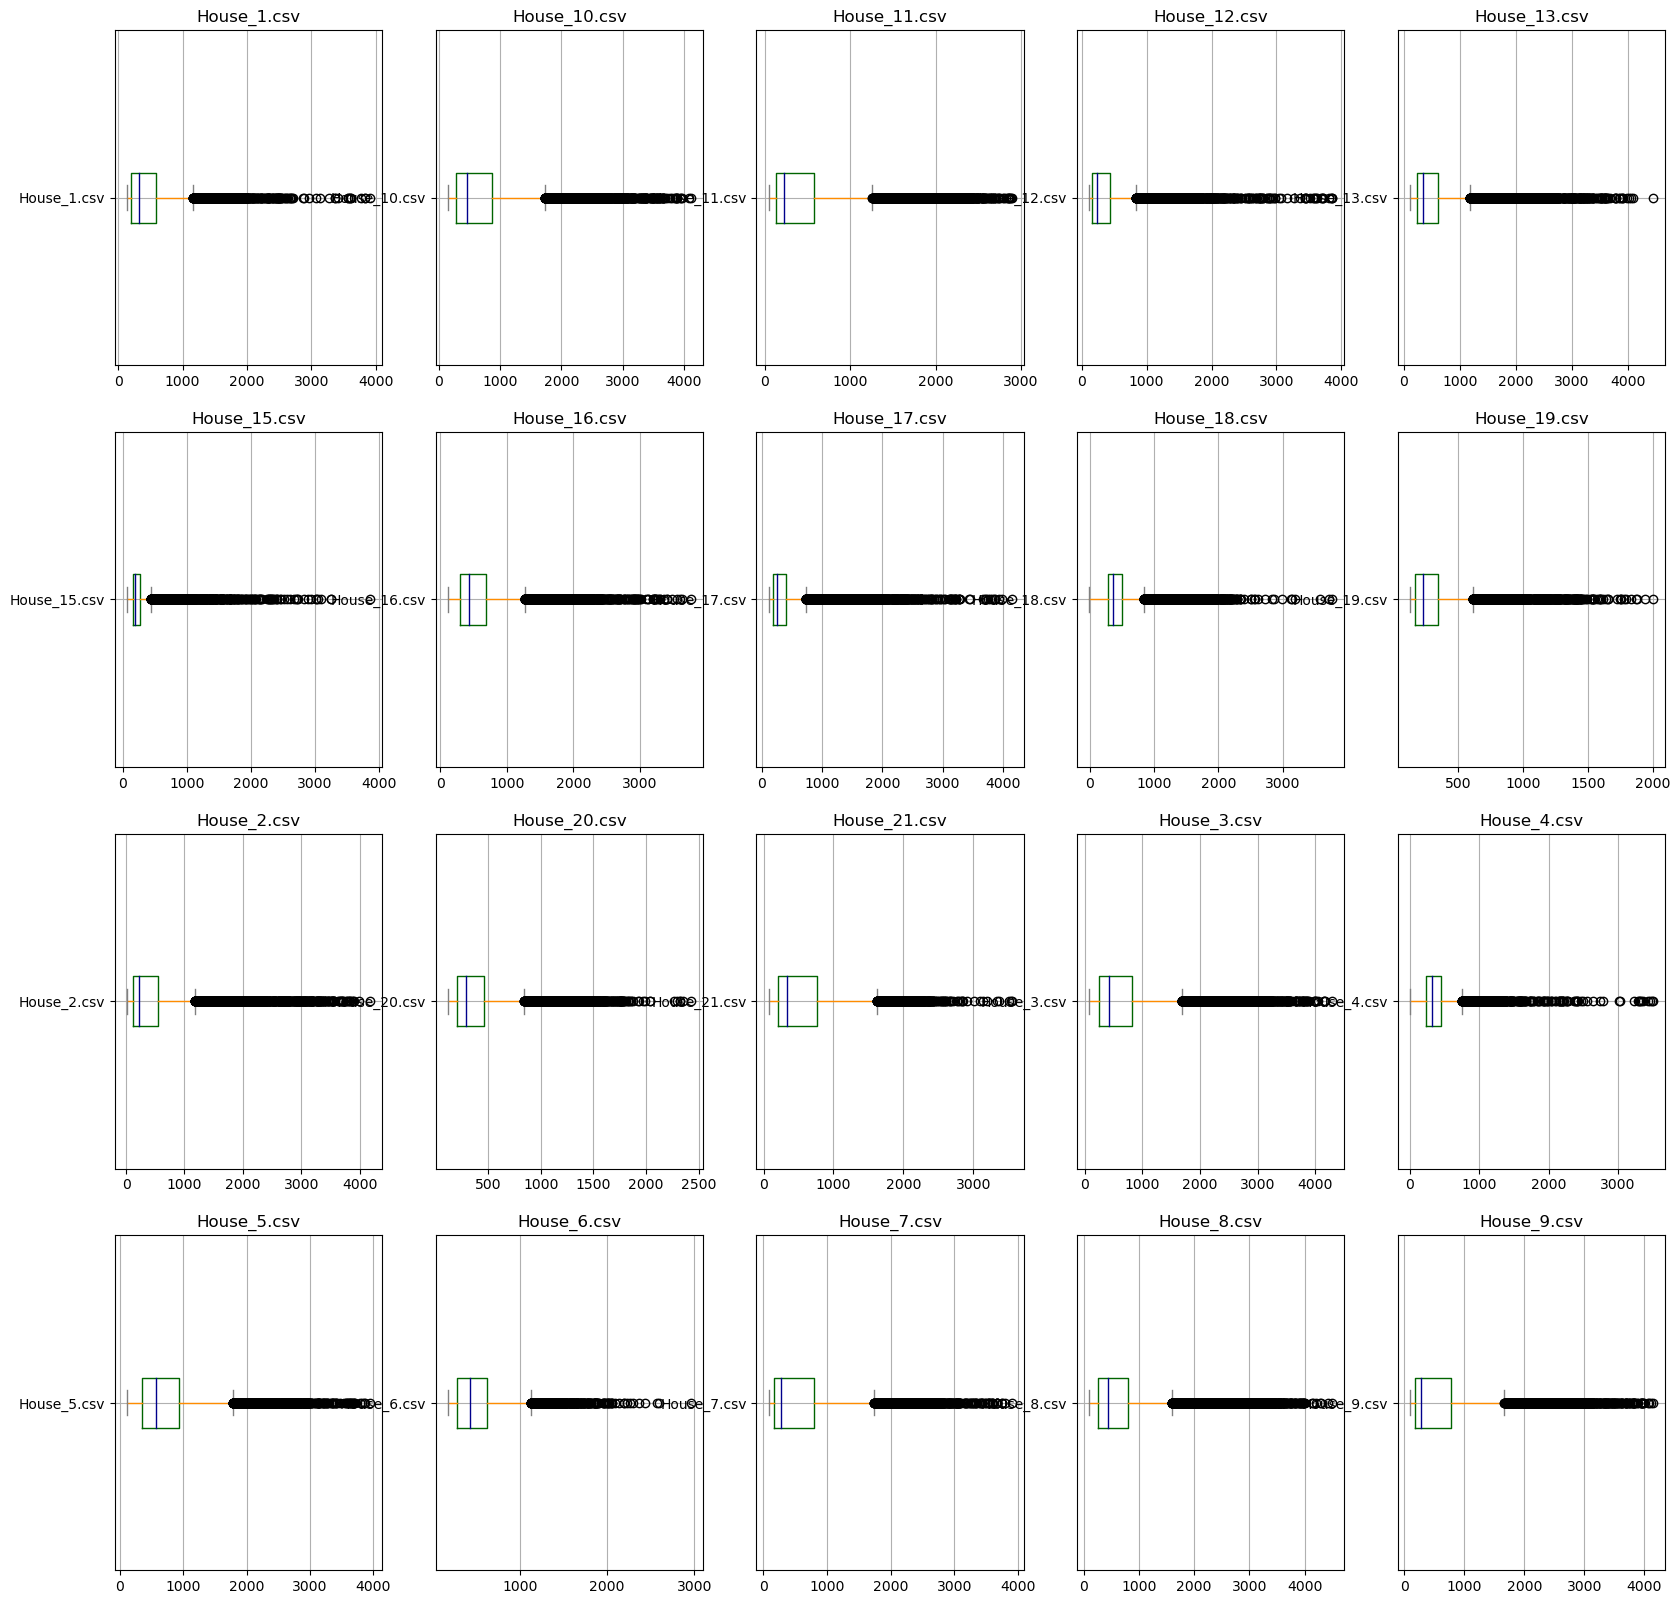

In [96]:
fig, axes = plt.subplots(4, 5, figsize=(20,20))
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')

for col, ax in zip(district.columns[1:], axes.flatten()):
    district[col].plot.box(vert=False, grid = True,ax = ax,color=color)
    ax.set_title(col)
    s = district[col].describe()
    q1 = s['25%']
    q3 = s['75%']
    iqr = q3-q1
    mi = q1-1.5*iqr
    ma = q3+1.5*iqr
    error = district[col][(district[col]<mi)|(district[col]>ma)]

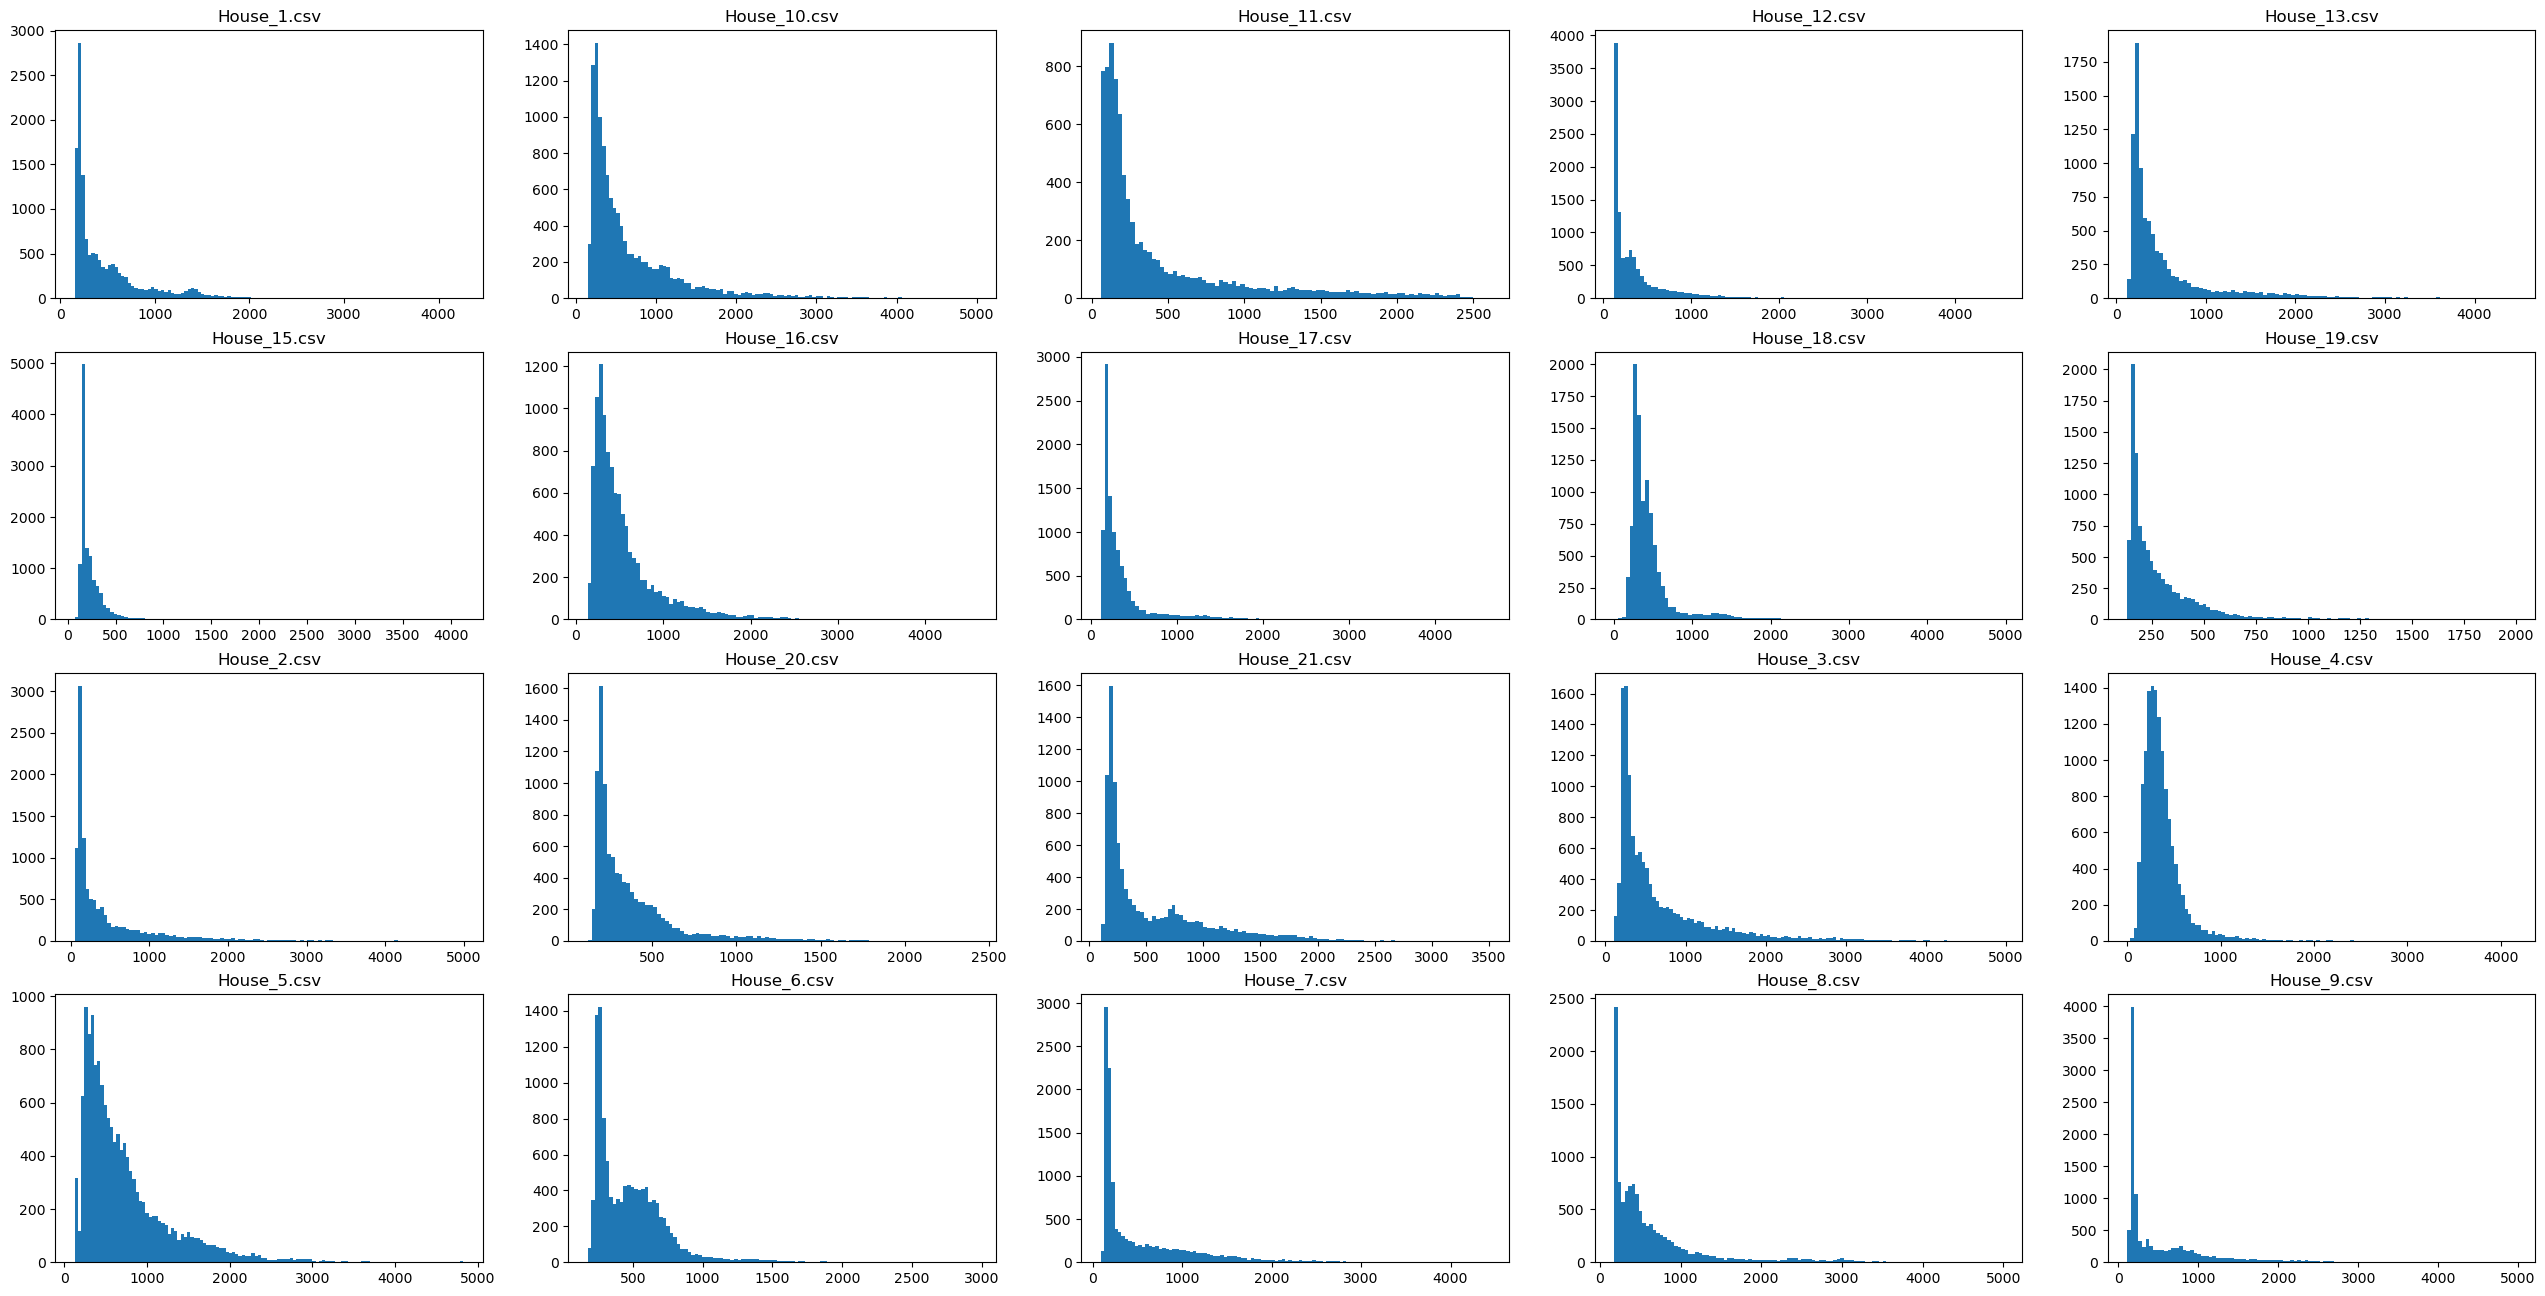

In [57]:
fig, axes = plt.subplots(4, 5, figsize=(32,16))
rawRecord = index.reset_index(inplace=False)
rawRecord.rename(columns={'index': 'HourlyUnix'}, inplace=True)

for f, ax in zip(file[1:], axes.flatten()):
    h = csv2HourlyAgg(f)
    merged = index.merge(h, how='outer', left_index=True, right_index=True)
    merged.reset_index(inplace=True)
    merged.rename(columns={'index': 'HourlyUnix'}, inplace=True)
    merged.rename(columns={'Aggregate': 'Load'}, inplace=True)
    pr = peakRate(merged)
    errHandler(merged)
    merged.rename(columns={'Load': f}, inplace=True)
    rawRecord = concat(rawRecord, merged, f)
    ax.hist(merged[f], bins="sqrt")
    ax.set_title(f)

In [97]:
district

,HourlyUnix,House_1.csv,House_10.csv,House_11.csv,House_12.csv,House_13.csv,House_15.csv,House_16.csv,House_17.csv,House_18.csv,...,House_2.csv,House_20.csv,House_21.csv,House_3.csv,House_4.csv,House_5.csv,House_6.csv,House_7.csv,House_8.csv,House_9.csv
0,1379458800,815.245441,388.300048,105.384378,139.023801,356.338985,341.226690,298.765687,127.680322,352.655322,...,93.307179,162.806495,393.129414,288.806945,185.626270,503.500498,702.695757,150.274334,297.190695,620.572584
1,1379462400,937.948521,356.949248,1131.576443,139.229756,217.006263,261.775531,175.571059,149.003182,215.592019,...,93.646667,173.212626,123.665885,238.871461,239.961911,545.792541,503.228843,193.105010,799.580253,322.292811
2,1379466000,1471.799787,824.099594,104.597516,165.367038,315.190511,99.742734,143.870300,234.623734,465.790944,...,63.625000,270.194987,918.272826,254.833520,217.856313,303.930455,210.777746,244.802947,907.874786,269.165276
3,1379469600,241.122525,165.633062,96.247057,187.587085,269.307276,161.598547,201.035416,266.901568,230.803352,...,91.045151,263.370644,128.662414,300.241330,310.796677,332.289143,262.490916,123.676094,2731.931943,121.796271
4,1379473200,152.919738,394.644934,123.076132,229.954687,175.359972,160.467070,418.012084,132.185188,261.086143,...,94.705686,157.576121,191.595768,485.518763,153.051312,571.030528,302.874169,229.921315,1049.756424,180.046052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15847,1436508000,224.322878,904.858425,270.465894,247.795518,780.322493,246.801008,398.111797,276.002369,346.283441,...,243.382414,298.127174,1000.633146,392.872336,206.591094,1522.650881,205.649888,299.044535,1940.290883,639.658749
15848,1436511600,213.994555,570.774552,155.771485,437.666424,484.958864,247.129395,1282.497721,251.612035,404.115499,...,1113.619598,541.417713,479.891588,521.725478,260.860300,391.959011,341.844691,509.352158,1535.937500,145.092592
15849,1436515200,220.898336,422.861237,549.851234,981.262430,1456.131871,181.258290,574.241054,378.814564,449.730190,...,1961.809545,279.695188,408.821096,3161.439469,657.082845,834.125225,349.157130,399.948380,285.205929,502.314517
15850,1436518800,197.615101,981.957438,735.885773,559.793519,3370.678638,254.386819,375.038829,399.132830,220.215700,...,343.297998,537.404164,1074.177626,111.116296,110.801675,1185.146684,435.983813,533.515231,259.809128,124.517257


In [98]:
district.to_csv('District.csv', index=False)

In [105]:
district = pd.read_csv('District.csv')

In [106]:
district

,HourlyUnix,House_1.csv,House_10.csv,House_11.csv,House_12.csv,House_13.csv,House_15.csv,House_16.csv,House_17.csv,House_18.csv,...,House_2.csv,House_20.csv,House_21.csv,House_3.csv,House_4.csv,House_5.csv,House_6.csv,House_7.csv,House_8.csv,House_9.csv
0,1379458800,815.245441,388.300048,105.384378,139.023801,356.338985,341.226690,298.765687,127.680322,352.655322,...,93.307179,162.806495,393.129414,288.806945,185.626270,503.500498,702.695757,150.274334,297.190695,620.572584
1,1379462400,937.948521,356.949248,1131.576443,139.229756,217.006263,261.775531,175.571059,149.003182,215.592019,...,93.646667,173.212626,123.665885,238.871461,239.961911,545.792541,503.228843,193.105010,799.580253,322.292811
2,1379466000,1471.799787,824.099594,104.597516,165.367038,315.190511,99.742734,143.870300,234.623734,465.790944,...,63.625000,270.194987,918.272826,254.833520,217.856313,303.930455,210.777746,244.802947,907.874786,269.165276
3,1379469600,241.122525,165.633062,96.247057,187.587085,269.307276,161.598547,201.035416,266.901568,230.803352,...,91.045151,263.370644,128.662414,300.241330,310.796677,332.289143,262.490916,123.676094,2731.931943,121.796271
4,1379473200,152.919738,394.644934,123.076132,229.954687,175.359972,160.467070,418.012084,132.185188,261.086143,...,94.705686,157.576121,191.595768,485.518763,153.051312,571.030528,302.874169,229.921315,1049.756424,180.046052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15847,1436508000,224.322878,904.858425,270.465894,247.795518,780.322493,246.801008,398.111797,276.002369,346.283441,...,243.382414,298.127174,1000.633146,392.872336,206.591094,1522.650881,205.649888,299.044535,1940.290883,639.658749
15848,1436511600,213.994555,570.774552,155.771485,437.666424,484.958864,247.129395,1282.497721,251.612035,404.115499,...,1113.619598,541.417713,479.891588,521.725478,260.860300,391.959011,341.844691,509.352158,1535.937500,145.092592
15849,1436515200,220.898336,422.861237,549.851234,981.262430,1456.131871,181.258290,574.241054,378.814564,449.730190,...,1961.809545,279.695188,408.821096,3161.439469,657.082845,834.125225,349.157130,399.948380,285.205929,502.314517
15850,1436518800,197.615101,981.957438,735.885773,559.793519,3370.678638,254.386819,375.038829,399.132830,220.215700,...,343.297998,537.404164,1074.177626,111.116296,110.801675,1185.146684,435.983813,533.515231,259.809128,124.517257


In [107]:
disDict = dict()
for col in district.columns[1:]:
    disDict[col] = district[col].mean()
srtKey = sorted(disDict, key=disDict.get)
srtValue = []

for col in srtKey:
    srtValue.append(disDict.get(col))

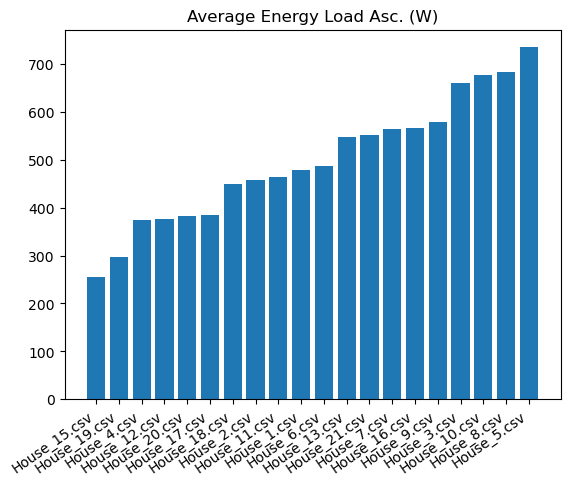

In [108]:
plt.bar(srtKey, srtValue)
plt.xticks(srtKey, rotation = 35, ha='right')
plt.title('Average Energy Load Asc. (W)')
plt.show()

In [116]:
block1 = srtKey[0:6]
block2 = srtKey[6:11]
block3 = srtKey[11:16]
block4 = srtKey[16:]

In [120]:
fn = 'blocks'
if os.path.exists(fn) == False:
    os.makedirs(fn)

In [140]:
bk1 = pd.DataFrame()
for col in block1:
    bk1 = bk1.merge(district[col], how='outer', left_index=True, right_index=True)
path1 = fn + '/Block1.csv'
bk1.to_csv(path1, index=False)

In [141]:
bk2 = pd.DataFrame()
for col in block2:
    bk2 = bk2.merge(district[col], how='outer', left_index=True, right_index=True)
path2 = fn + '/Block2.csv'
bk2.to_csv(path2, index=False)

In [142]:
bk3 = pd.DataFrame()
for col in block3:
    bk3 = bk3.merge(district[col], how='outer', left_index=True, right_index=True)
path3 = fn + '/Block3.csv'
bk3.to_csv(path3, index=False)

In [143]:
bk4 = pd.DataFrame()
for col in block4:
    bk4 = bk4.merge(district[col], how='outer', left_index=True, right_index=True)
path4 = fn + '/Block4.csv'
bk4.to_csv(path4, index=False)

In [2]:
fn = 'blocks'
block1 = pd.read_csv(fn+'/Block1.csv')
block2 = pd.read_csv(fn+'/Block2.csv')
block3 = pd.read_csv(fn+'/Block3.csv')
block4 = pd.read_csv(fn+'/Block4.csv')
district = pd.read_csv('District.csv')

In [4]:
block2

,House_18.csv,House_2.csv,House_11.csv,House_1.csv,House_6.csv
0,352.655322,93.307179,105.384378,815.245441,702.695757
1,215.592019,93.646667,1131.576443,937.948521,503.228843
2,465.790944,63.625000,104.597516,1471.799787,210.777746
3,230.803352,91.045151,96.247057,241.122525,262.490916
4,261.086143,94.705686,123.076132,152.919738,302.874169
...,...,...,...,...,...
15847,346.283441,243.382414,270.465894,224.322878,205.649888
15848,404.115499,1113.619598,155.771485,213.994555,341.844691
15849,449.730190,1961.809545,549.851234,220.898336,349.157130
15850,220.215700,343.297998,735.885773,197.615101,435.983813


In [6]:
district

,HourlyUnix,House_1.csv,House_10.csv,House_11.csv,House_12.csv,House_13.csv,House_15.csv,House_16.csv,House_17.csv,House_18.csv,...,House_2.csv,House_20.csv,House_21.csv,House_3.csv,House_4.csv,House_5.csv,House_6.csv,House_7.csv,House_8.csv,House_9.csv
0,1379458800,815.245441,388.300048,105.384378,139.023801,356.338985,341.226690,298.765687,127.680322,352.655322,...,93.307179,162.806495,393.129414,288.806945,185.626270,503.500498,702.695757,150.274334,297.190695,620.572584
1,1379462400,937.948521,356.949248,1131.576443,139.229756,217.006263,261.775531,175.571059,149.003182,215.592019,...,93.646667,173.212626,123.665885,238.871461,239.961911,545.792541,503.228843,193.105010,799.580253,322.292811
2,1379466000,1471.799787,824.099594,104.597516,165.367038,315.190511,99.742734,143.870300,234.623734,465.790944,...,63.625000,270.194987,918.272826,254.833520,217.856313,303.930455,210.777746,244.802947,907.874786,269.165276
3,1379469600,241.122525,165.633062,96.247057,187.587085,269.307276,161.598547,201.035416,266.901568,230.803352,...,91.045151,263.370644,128.662414,300.241330,310.796677,332.289143,262.490916,123.676094,2731.931943,121.796271
4,1379473200,152.919738,394.644934,123.076132,229.954687,175.359972,160.467070,418.012084,132.185188,261.086143,...,94.705686,157.576121,191.595768,485.518763,153.051312,571.030528,302.874169,229.921315,1049.756424,180.046052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15847,1436508000,224.322878,904.858425,270.465894,247.795518,780.322493,246.801008,398.111797,276.002369,346.283441,...,243.382414,298.127174,1000.633146,392.872336,206.591094,1522.650881,205.649888,299.044535,1940.290883,639.658749
15848,1436511600,213.994555,570.774552,155.771485,437.666424,484.958864,247.129395,1282.497721,251.612035,404.115499,...,1113.619598,541.417713,479.891588,521.725478,260.860300,391.959011,341.844691,509.352158,1535.937500,145.092592
15849,1436515200,220.898336,422.861237,549.851234,981.262430,1456.131871,181.258290,574.241054,378.814564,449.730190,...,1961.809545,279.695188,408.821096,3161.439469,657.082845,834.125225,349.157130,399.948380,285.205929,502.314517
15850,1436518800,197.615101,981.957438,735.885773,559.793519,3370.678638,254.386819,375.038829,399.132830,220.215700,...,343.297998,537.404164,1074.177626,111.116296,110.801675,1185.146684,435.983813,533.515231,259.809128,124.517257


In [25]:
block1.loc[:, 'b1avg'] = block1.mean(axis=1)
block2.loc[:, 'b2avg'] = block2.mean(axis=1)
block3.loc[:, 'b3avg'] = block3.mean(axis=1)
block4.loc[:, 'b4avg'] = block4.mean(axis=1)
district.loc[:, 'TotalLoad'] = district[district.columns[1:]].sum(axis=1)

In [24]:
a = district[district.columns[1:]].sum(axis=1)
a

0         6470.932613
1         6988.716816
2         7687.920274
3         6637.537564
4         5733.586660
             ...     
15847    10939.222974
15848    10206.654230
15849    14245.224701
15850    11947.945996
15851    10446.687828
Length: 15852, dtype: float64

In [26]:
district

,HourlyUnix,House_1.csv,House_10.csv,House_11.csv,House_12.csv,House_13.csv,House_15.csv,House_16.csv,House_17.csv,House_18.csv,...,House_20.csv,House_21.csv,House_3.csv,House_4.csv,House_5.csv,House_6.csv,House_7.csv,House_8.csv,House_9.csv,TotalLoad
0,1379458800,815.245441,388.300048,105.384378,139.023801,356.338985,341.226690,298.765687,127.680322,352.655322,...,162.806495,393.129414,288.806945,185.626270,503.500498,702.695757,150.274334,297.190695,620.572584,6470.932613
1,1379462400,937.948521,356.949248,1131.576443,139.229756,217.006263,261.775531,175.571059,149.003182,215.592019,...,173.212626,123.665885,238.871461,239.961911,545.792541,503.228843,193.105010,799.580253,322.292811,6988.716816
2,1379466000,1471.799787,824.099594,104.597516,165.367038,315.190511,99.742734,143.870300,234.623734,465.790944,...,270.194987,918.272826,254.833520,217.856313,303.930455,210.777746,244.802947,907.874786,269.165276,7687.920274
3,1379469600,241.122525,165.633062,96.247057,187.587085,269.307276,161.598547,201.035416,266.901568,230.803352,...,263.370644,128.662414,300.241330,310.796677,332.289143,262.490916,123.676094,2731.931943,121.796271,6637.537564
4,1379473200,152.919738,394.644934,123.076132,229.954687,175.359972,160.467070,418.012084,132.185188,261.086143,...,157.576121,191.595768,485.518763,153.051312,571.030528,302.874169,229.921315,1049.756424,180.046052,5733.586660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15847,1436508000,224.322878,904.858425,270.465894,247.795518,780.322493,246.801008,398.111797,276.002369,346.283441,...,298.127174,1000.633146,392.872336,206.591094,1522.650881,205.649888,299.044535,1940.290883,639.658749,10939.222974
15848,1436511600,213.994555,570.774552,155.771485,437.666424,484.958864,247.129395,1282.497721,251.612035,404.115499,...,541.417713,479.891588,521.725478,260.860300,391.959011,341.844691,509.352158,1535.937500,145.092592,10206.654230
15849,1436515200,220.898336,422.861237,549.851234,981.262430,1456.131871,181.258290,574.241054,378.814564,449.730190,...,279.695188,408.821096,3161.439469,657.082845,834.125225,349.157130,399.948380,285.205929,502.314517,14245.224701
15850,1436518800,197.615101,981.957438,735.885773,559.793519,3370.678638,254.386819,375.038829,399.132830,220.215700,...,537.404164,1074.177626,111.116296,110.801675,1185.146684,435.983813,533.515231,259.809128,124.517257,11947.945996


In [31]:
data = pd.DataFrame()
data = data.merge(district['HourlyUnix'], how='outer', left_index=True, right_index=True)
data = data.merge(district['TotalLoad'], how='outer', left_index=True, right_index=True)
data = data.merge(block1['b1avg'], how='outer', left_index=True, right_index=True)
data = data.merge(block2['b2avg'], how='outer', left_index=True, right_index=True)
data = data.merge(block3['b3avg'], how='outer', left_index=True, right_index=True)
data = data.merge(block4['b4avg'], how='outer', left_index=True, right_index=True)

In [33]:
data.to_csv('Data.csv', index=False)

NameError: name 'data' is not defined

In [34]:
data

NameError: name 'data' is not defined

In [1]:
from FGEnv import FGEnv
from Agent import Agent
from FGPolicy import FGPolicy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

HourlyUnix    1.407991e+09
TotalLoad     9.976414e+03
b1avg         3.452780e+02
b2avg         4.672634e+02
b3avg         5.622725e+02
b4avg         6.892666e+02
dtype: float64


In [2]:
def nmlz(data):
    minn = data.min(axis=0)
    maxn = data.max(axis=0)
    return (data - minn) / (maxn - minn)


HourlyUnix    1.407991e+09
TotalLoad     9.976414e+03
b1avg         3.452780e+02
b2avg         4.672634e+02
b3avg         5.622725e+02
b4avg         6.892666e+02
dtype: float64
1/1 [==============================] - 1s 514ms/step
[[0.00977346]
 [0.01360063]
 [0.01198038]
 [0.0066786 ]
 [0.00467045]
 [0.01199366]
 [0.01998905]
 [0.02129419]
 [0.03691203]
 [0.02090577]]
Epoch 1/100
365/365 [==============================] - 4s 6ms/step - loss: 8.9836e-04 - accuracy: 1.1416e-04 - val_loss: 2.9241e-06 - val_accuracy: 1.4100e-04
Epoch 2/100
365/365 [==============================] - 1s 4ms/step - loss: 4.5527e-07 - accuracy: 1.1416e-04 - val_loss: 1.0178e-06 - val_accuracy: 1.4100e-04
Epoch 3/100
365/365 [==============================] - 1s 4ms/step - loss: 1.8392e-07 - accuracy: 1.1416e-04 - val_loss: 5.5140e-07 - val_accuracy: 1.4100e-04
Epoch 4/100
365/365 [==============================] - 1s 4ms/step - loss: 1.6918e-07 - accuracy: 1.1416e-04 - val_loss: 1.8076e-07 - val_accuracy: 1.41

Epoch 50/100
365/365 [==============================] - 1s 4ms/step - loss: 1.6808e-06 - accuracy: 1.1416e-04 - val_loss: 1.5453e-05 - val_accuracy: 1.4100e-04
Epoch 51/100
365/365 [==============================] - 1s 4ms/step - loss: 4.9619e-06 - accuracy: 1.1416e-04 - val_loss: 1.4557e-07 - val_accuracy: 1.4100e-04
Epoch 52/100
365/365 [==============================] - 1s 4ms/step - loss: 3.1272e-07 - accuracy: 1.1416e-04 - val_loss: 2.1560e-07 - val_accuracy: 1.4100e-04
Epoch 53/100
365/365 [==============================] - 1s 4ms/step - loss: 7.3820e-08 - accuracy: 1.1416e-04 - val_loss: 8.1182e-08 - val_accuracy: 1.4100e-04
Epoch 54/100
365/365 [==============================] - 1s 4ms/step - loss: 2.4290e-07 - accuracy: 1.1416e-04 - val_loss: 1.1013e-06 - val_accuracy: 1.4100e-04
Epoch 55/100
365/365 [==============================] - 1s 4ms/step - loss: 2.5613e-06 - accuracy: 1.1416e-04 - val_loss: 1.3922e-06 - val_accuracy: 1.4100e-04
Epoch 56/100
365/365 [==================

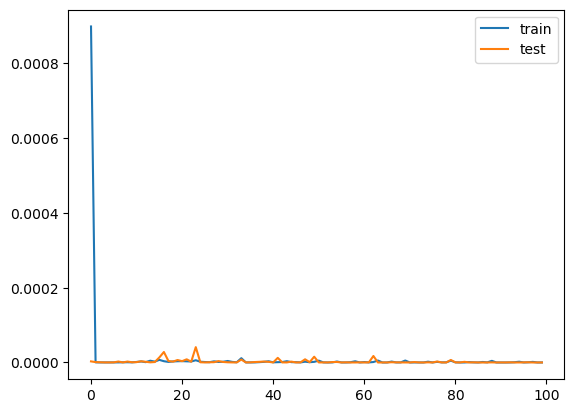

In [9]:
a = Agent(1, 5)
a.build_model()
dd = pd.read_csv('Data.csv')
print(dd.mean(axis=0))
mean = dd.mean()['TotalLoad']
std = dd.std()['TotalLoad']
dd = nmlz(dd)
x = dd.drop(columns='TotalLoad')[:8760].values
y = dd[:8760].TotalLoad
xt = dd.drop(columns='TotalLoad')[8760:].values
yt = dd[8760:].TotalLoad
#
# print(x.shape[0])
x = x.reshape(x.shape[0], 1, x.shape[1])
xt = xt.reshape(xt.shape[0], 1, xt.shape[1])
q = a.model.predict(x[0:10])
print(q)
# print(q*std + mean)
# print(y[0:10]*std + mean)


history = a.model.fit(x, y, epochs=100, batch_size=24, validation_data=(xt, yt))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
rt = a.model.predict(xt)

222/222 [==============================] - 0s 1ms/step


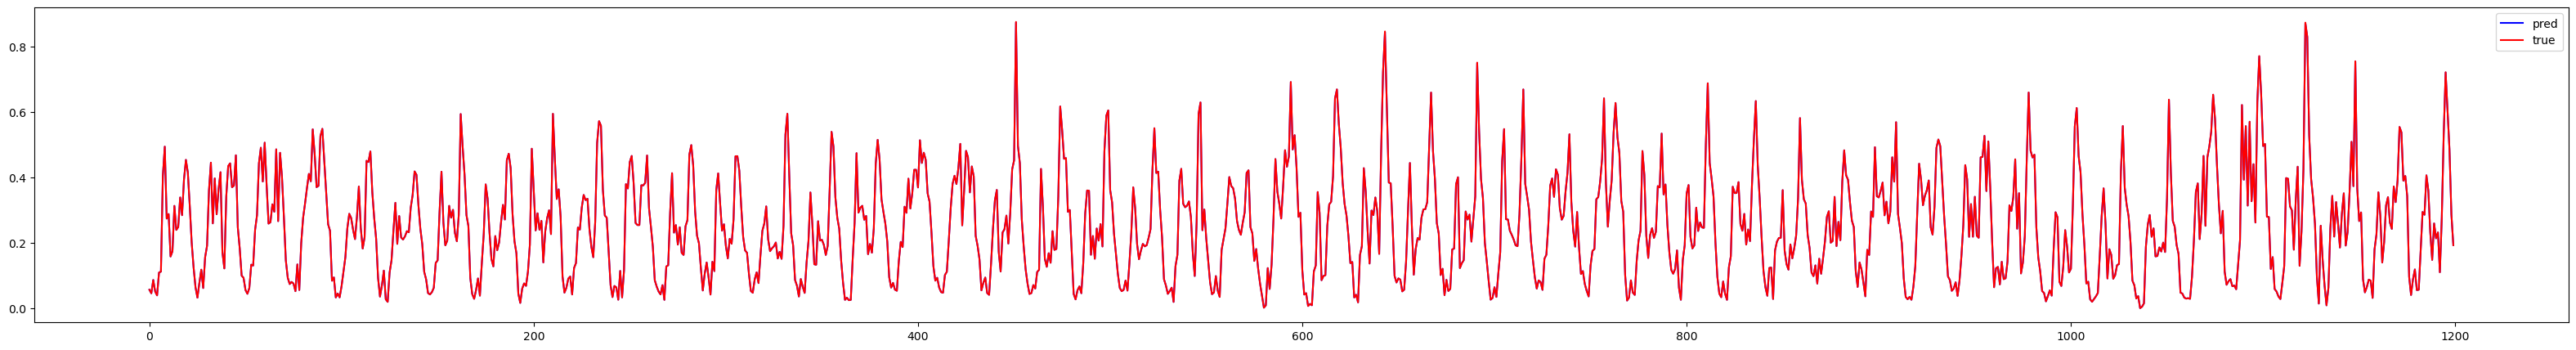

In [34]:
fig = plt.figure(figsize=(40,5))
plt.plot(rt[0:1200], label='pred', color='b')
plt.plot(yt.reset_index().drop(columns='index')[0:1200], label='true', color='r')
plt.legend()
plt.show()

In [3]:
yt.reset_index()

NameError: name 'yt' is not defined

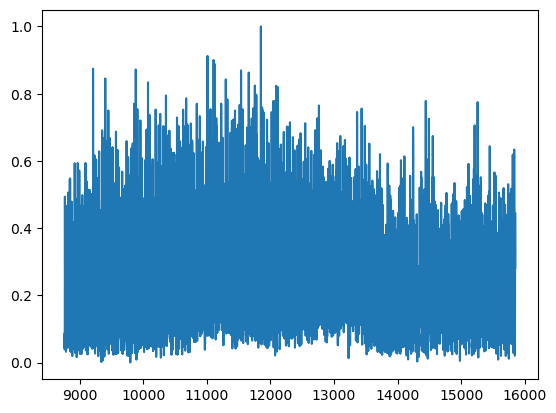

In [15]:
plt.plot(yt)

In [6]:
import random

In [7]:
random.uniform(0, 1)

0.8097057856278507

In [8]:
fg.env.restore(0.8097057856278507)

HourlyUnix    1.379478e+09
TotalLoad     2.273806e+04
b1avg         1.899117e+04
b2avg         1.898774e+04
b3avg         1.899544e+04
b4avg         1.903894e+04
dtype: float64

In [3]:
from ForecastGame import ForecastGame

In [4]:
fg = ForecastGame()
fg.explore(200)

finished


In [5]:
fg.memory

deque([[array([[0.03141758, 0.26032217, 0.30125352, 0.42449222, 0.16466717]]),
        0.48119000920137633,
        0,
        6648],
       [array([[0.41940572, 0.09934565, 0.19474302, 0.02763396, 0.03218237]]),
        0.6122184001137059,
        0,
        6311],
       [array([[0.39814523, 0.14997985, 0.13225574, 0.11975786, 0.09842292]]),
        0.235739557594129,
        0,
        2675],
       [array([[0.16875907, 0.18490438, 0.45678866, 0.27747574, 0.14024549]]),
        0.4645174181305376,
        0,
        6549],
       [array([[0.41316005, 0.28818579, 0.12088698, 0.31452379, 0.1534517 ]]),
        0.7261898954818848,
        0,
        41],
       [array([[0.00258659, 0.18218942, 0.13468839, 0.19341265, 0.33045383]]),
        0.6745526819436254,
        0,
        458],
       [array([[0.02889408, 0.02652976, 0.0594412 , 0.02281626, 0.08424709]]),
        0.7877702939385272,
        0,
        3951],
       [array([[0.24925872, 0.08979947, 0.29564528, 0.15983732, 0.537234

In [6]:
fg.critic.model.predict(fg.env.test_x)

222/222 [==============================] - 1s 1ms/step


array([[0.00360195],
       [0.00247009],
       [0.00169318],
       ...,
       [0.00015442],
       [0.00523041],
       [0.00239782]], dtype=float32)

In [12]:
fg.train(150)

load success


R:0 L:0.0000 T:6 P:0.010 H:3924: 100%|███████████████████████████████████████████████| 150/150 [15:06<00:00,  6.04s/it]

saved


In [13]:
fg.test()

222/222 [==============================] - 0s 2ms/step


array([[18971.027 ],
       [18713.164 ],
       [17345.9   ],
       ...,
       [10134.031 ],
       [ 5129.8784],
       [10972.617 ]], dtype=float32)

In [9]:
fg.env.test_t

8760      5191.429193
8761      4937.627182
8762      5884.276978
8763      5063.227479
8764      4790.671477
             ...     
15847    10939.222974
15848    10206.654230
15849    14245.224701
15850    11947.945996
15851    10446.687828
Name: TotalLoad, Length: 7092, dtype: float64

In [37]:
dd.describe()

,HourlyUnix,TotalLoad,b1avg,b2avg,b3avg,b4avg
count,1.585200e+04,15852.000000,15852.000000,15852.000000,15852.000000,15852.000000
mean,1.407991e+09,9976.413838,345.277973,467.263413,562.272526,689.266575
std,1.647440e+07,3607.167048,158.963727,204.258195,311.944214,332.205440
min,1.379459e+09,3881.925210,135.033356,131.608178,139.311659,182.811022
25%,1.393725e+09,7061.518872,219.091047,312.117859,311.251327,426.400884
50%,1.407991e+09,9647.167983,307.266763,432.383956,493.489665,619.303041
75%,1.422256e+09,12266.601412,424.483194,585.492266,734.234893,894.005041
max,1.436522e+09,27169.559333,1254.378369,1588.607518,2135.162771,2627.920248


In [36]:
dd = pd.read_csv('Data.csv')
print(dd.mean(axis=0))
minn = dd.min(axis=0)['TotalLoad']
maxn = dd.max(axis=0)['TotalLoad']
# dd = nmlz(dd)
x = dd.drop(columns='TotalLoad')[:8760].values
y = dd[:8760].TotalLoad
xt = dd.drop(columns='TotalLoad')[8760:].values
yt = dd[8760:].TotalLoad
x = x.reshape(x.shape[0], 1, x.shape[1])
xt = xt.reshape(xt.shape[0], 1, xt.shape[1])

HourlyUnix    1.407991e+09
TotalLoad     9.976414e+03
b1avg         3.452780e+02
b2avg         4.672634e+02
b3avg         5.622725e+02
b4avg         6.892666e+02
dtype: float64


In [28]:
fg.critic.model.predict(x)

274/274 [==============================] - 0s 1ms/step


array([[-0.00908264],
       [-0.01066593],
       [-0.01275121],
       ...,
       [-0.00747823],
       [-0.00087884],
       [ 0.00068402]], dtype=float32)

In [29]:
fg.env.train_x

array([[[ 5.92355115e+04, -1.58788035e-01, -1.48923140e-01,
         -1.51071981e-01, -1.50830078e-01]],

       [[ 5.92356661e+04, -1.58579595e-01, -1.41943432e-01,
         -1.57834711e-01, -1.45855385e-01]],

       [[ 5.92358206e+04, -1.58183109e-01, -1.46799241e-01,
         -1.50451730e-01, -1.42102912e-01]],

       ...,

       [[ 6.05892428e+04, -1.47138558e-01, -1.50907136e-01,
         -1.34173017e-01, -1.38028793e-01]],

       [[ 6.05893974e+04, -1.50515428e-01, -1.47942149e-01,
         -1.42278450e-01, -1.52532834e-01]],

       [[ 6.05895520e+04, -1.55868903e-01, -1.47872905e-01,
         -1.42534040e-01, -1.54389367e-01]]])

In [30]:
x

array([[[0.00000000e+00, 4.38597581e-02, 1.93719674e-01, 1.12485616e-01,
         7.63313649e-02]],

       [[6.30875024e-05, 4.81962895e-02, 3.05278327e-01, 3.35779290e-02,
         1.23711182e-01]],

       [[1.26175005e-04, 5.64450531e-02, 2.27666555e-01, 1.19722715e-01,
         1.59450368e-01]],

       ...,

       [[5.52457258e-01, 2.86223589e-01, 1.62008896e-01, 3.09663084e-01,
         1.98252967e-01]],

       [[5.52520346e-01, 2.15968842e-01, 2.09399129e-01, 2.15088723e-01,
         6.01140292e-02]],

       [[5.52583433e-01, 1.04591400e-01, 2.10505876e-01, 2.12106490e-01,
         4.24320898e-02]]])

In [5]:
fg.env.data.TotalLoad.max(axis=0)

27169.55933265635

In [32]:
maxn

27169.55933265635

In [7]:
fg.env.train_t

0        6470.932613
1        6988.716816
2        7687.920274
3        6637.537564
4        5733.586660
            ...     
8755    15511.444198
8756    14670.292099
8757    11027.783046
8758     8606.344061
8759     7663.690429
Name: TotalLoad, Length: 8760, dtype: float64

In [5]:
fg.env.train_t[fg.env.state]

16836.43486688827

In [7]:
fg.train(1)

load success


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[[0.19197527 0.77493301 0.18881332 0.5622079  0.17331441]]


D:\SBDE_L\SBDEDissertation\Data\REFIT\ForecastGame.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(random.sample(self.memory, num))


[[0.27228566 0.12080936 0.22270956 0.50483753 0.36264902]]
[[0.42054129 0.50270672 0.22347265 0.16484121 0.21087505]]
[[0.37530755 0.20279146 0.29884996 0.29118676 0.22723819]]
[[0.15330263 0.02527235 0.06558177 0.0806755  0.09762156]]
[[0.49542616 0.07085627 0.03307939 0.04229755 0.24043498]]
[[0.44230648 0.05296409 0.04692013 0.03617553 0.11779625]]
[[0.42192922 0.08676592 0.28851944 0.29533012 0.15199782]]
[[0.50236578 0.12391232 0.26777028 0.36307987 0.28304445]]
[[0.18080878 0.16036354 0.23442828 0.2642869  0.31562386]]
[[0.2796669  0.28105349 0.15361071 0.15134688 0.48083292]]
[[0.03255315 0.19215446 0.22532803 0.17302489 0.08654219]]
[[0.03501356 0.0687798  0.04853239 0.04001239 0.21127607]]
[[0.26029903 0.31690772 0.1302284  0.22313986 0.20185335]]
[[0.48249322 0.11400332 0.17518409 0.27843025 0.06573795]]
[[0.15210397 0.10729229 0.35731248 0.36213737 0.57498902]]
[[0.18995647 0.2036425  0.3091775  0.22505633 0.11123564]]
[[0.30464955 0.04836645 0.05818302 0.05377169 0.05145444

R:0 L:0.0671 T:6 P:1.000 H:0: 100%|██████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]

[[0.10308498 0.01802694 0.25698753 0.03246356 0.0150509 ]]
saved


In [8]:
fg.test()

222/222 [==============================] - 1s 2ms/step


array([[15058.176],
       [14937.004],
       [15370.762],
       ...,
       [15074.064],
       [17433.875],
       [14622.25 ]], dtype=float32)

In [1]:
from ForecastGame import ForecastGame
from FGEnv import FGEnv
from Agent import Agent
from FGPolicy import FGPolicy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
fg = ForecastGame()
fg.explore(240)

finished


In [3]:
fg.memory

deque([[array([[0.04385976, 0.19371967, 0.11248562, 0.07633136]]),
        1,
        0,
        1,
        3167],
       [array([[0.15962017, 0.16284061, 0.26211015, 0.10683947]]),
        8,
        0,
        -1,
        2647],
       [array([[0.29473308, 0.09793312, 0.1051985 , 0.33448334]]),
        1,
        0,
        -1,
        5806],
       [array([[0.14853776, 0.09931805, 0.11130743, 0.08065624]]),
        7,
        0,
        -1,
        1409],
       [array([[0.35076749, 0.19918901, 0.19980331, 0.35777069]]),
        6,
        0,
        -1,
        701],
       [array([[0.05463312, 0.03489786, 0.04302923, 0.11881985]]),
        0,
        0,
        1,
        6478],
       [array([[0.18801   , 0.24626055, 0.25370688, 0.16613997]]),
        7,
        0,
        -1,
        260],
       [array([[0.17694205, 0.55356465, 0.54105588, 0.29167662]]),
        3,
        0,
        -1,
        8446],
       [array([[0.19942087, 0.08052455, 0.28731341, 0.12581534]]),
        1

In [4]:
fg.env.reset()

4385

In [ ]:
fg.train(1500)

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]D:\SBDE_L\SBDEDissertation\Data\REFIT\ForecastGame.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(random.sample(self.memory, num))
R:-74 L:0.227112 T:27 P:0.723 H:3921:   9%|███▌                                  | 141/1500 [58:09<10:22:13, 27.47s/it]

In [7]:
len(set(fg.env.train_c))

353

In [9]:
fg.env.action_size

466.0

In [15]:
fg.dummy_action.shape

(1, 466)

In [4]:
fg.env.cateRe(5)

16381.925210037458

In [20]:
fg.env.data.TotalLoad.max()

27169.55933265635

In [6]:
a = [30,0.2,2,0.1]

In [7]:
a = np.array(a)

In [8]:
a = a.reshape(1, *a.shape)

In [9]:
a.shape

(1, 4)

In [10]:
np.argmax(fg.get_q_value(a, fg.dummy_action))

140

In [24]:
fg.env.cateRe(175)

12631.925210037458

In [5]:
(fg.env.data.TotalLoad.max() - fg.env.minn) / 2500

9.315053649047558

In [8]:
np.argmax(fg.get_q_value(fg.env.train_x[88], fg.dummy_action))

5

In [31]:
fg.env.train_t[20:30]

20    11172.619500
21    11398.606784
22     9394.001894
23     9392.942713
24     6914.589638
25     7232.129366
26     4314.829444
27     6457.058351
28     4887.946118
29     6933.383633
Name: TotalLoad, dtype: float64

In [52]:
dd[20:30]

,HourlyUnix,TotalLoad,b1avg,b2avg,b3avg,b4avg
20,1379530800,11172.619500,500.173869,410.658120,665.299362,697.947218
21,1379534400,11398.606784,419.466244,370.013881,904.278381,627.587002
22,1379538000,9394.001894,430.719711,365.171811,518.466415,597.873123
23,1379541600,9392.942713,349.873400,296.687558,716.875424,556.471851
24,1379545200,6914.589638,246.143010,361.310227,352.424326,467.264703
25,1379548800,7232.129366,190.646586,450.665822,364.170808,503.516676
26,1379552400,4314.829444,187.207289,220.294325,145.232016,340.988501
27,1379556000,6457.058351,180.248839,371.784723,340.985063,452.929096
28,1379559600,4887.946118,199.324965,290.376702,295.967668,190.068619
29,1379563200,6933.383633,153.902257,361.916765,229.679593,762.997075


In [18]:
ipt = [fg.env.test_x, np.ones(shape=(len(fg.env.test_t), fg.pred_size))]

In [7]:
ipt[1].shape

(7092, 467)

In [19]:
q = fg.q.predict(ipt)

222/222 [==============================] - 0s 2ms/step


In [22]:
pred = np.argmax(q,axis=1)
pred

array([202, 202, 202, ..., 202, 202, 202], dtype=int64)

In [37]:
xt

array([[[0.55264652, 0.05036786, 0.07852412, 0.11048829, 0.02888141]],

       [[0.55270961, 0.04598491, 0.05804772, 0.07970928, 0.05259777]],

       [[0.5527727 , 0.05080522, 0.0704741 , 0.12991016, 0.08560067]],

       ...,

       [[0.99987382, 0.27672275, 0.39442784, 0.26503967, 0.40615647]],

       [[0.99993691, 0.17700684, 0.1750114 , 0.47913086, 0.18473464]],

       [[1.        , 0.19162213, 0.30491349, 0.14001827, 0.27045058]]])

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [89]:
file_path = 'rewardsep2t3200016000.5.txt'  # 替换为你的文件路径
mode = 'r'  # 以只读模式打开文件，如果要写入文件可以使用 'w' 模式
r3 = []

with open(file_path, mode) as file:
    l = file.readlines()
    for i in l:
        r = int(i.strip())  # 读取文件内容
        r3.append(r)

Text(0.5, 1.0, 'Rewards History - Experiment 2, 4th Training')

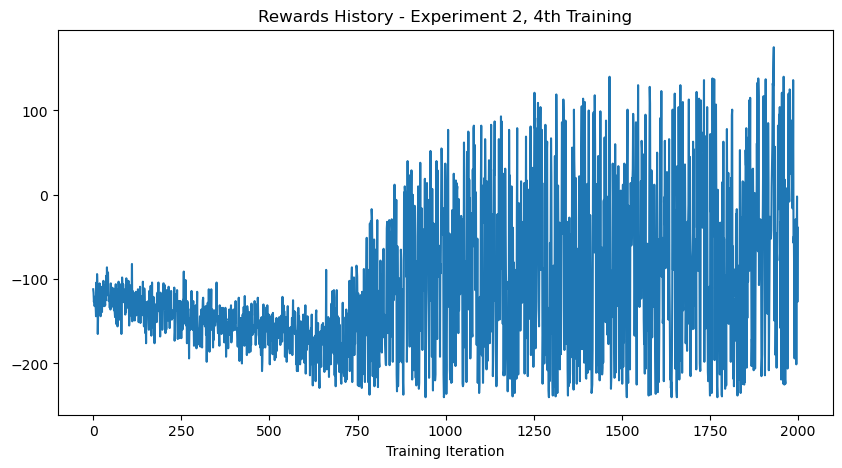

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(r3)
plt.xlabel('Training Iteration')
plt.title('Rewards History - Experiment 2, 4th Training')

In [3]:
from ForecastGame import ForecastGame

In [2]:
fg = ForecastGame()
fg.train(700)

load success


  0%|                                                                                          | 0/700 [00:00<?, ?it/s]D:\SBDE_L\SBDEDissertation\Data\REFIT\ForecastGame.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(random.sample(self.memory, num))
R:-112 L:0.242595 T:16 P:0.970 H:12:   1%|▍                                          | 7/700 [01:58<3:15:22, 16.92s/it]


KeyboardInterrupt: 

In [149]:
fg = ForecastGame()
fg.actor.model.load_weights('temp52.h5')
fg.actor.model.summary()

Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 1, 4)]       0           []                               
                                                                                                  
 dense_74 (Dense)               (None, 1, 128)       640         ['input_39[0][0]']               
                                                                                                  
 dense_75 (Dense)               (None, 1, 64)        8256        ['dense_74[0][0]']               
                                                                                                  
 prediction (InputLayer)        [(None, 10)]         0           []                               
                                                                                           

In [150]:
import numpy as np
ipt = [fg.env.test_x, np.ones(shape=(len(fg.env.test_x), fg.pred_size))]
q = fg.q.predict(ipt)

222/222 [==============================] - 0s 1ms/step


In [151]:
pred = np.argmax(q, axis=2)

In [152]:
count = 0
for i in range(len(fg.env.test_c)):
    if pred[i] == fg.env.test_c.values[i]:
        count += 1
count / len(fg.env.test_c)

0.5940496333897349

In [153]:
len(fg.env.test_c)

7092

In [138]:
fg.env.test_c.values[0]

0.0

In [17]:
q[0]

array([[-0.00447735,  0.01580399, -0.01482442,  0.02616313, -0.03369209,
        -0.02249244, -0.01934963, -0.02527221, -0.02194256, -0.0172501 ]],
      dtype=float32)

In [45]:
p = fg.test()

222/222 [==============================] - 0s 1ms/step


In [47]:
p[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [49]:
fg.env.test_t

8760      5191.429193
8761      4937.627182
8762      5884.276978
8763      5063.227479
8764      4790.671477
             ...     
15847    10939.222974
15848    10206.654230
15849    14245.224701
15850    11947.945996
15851    10446.687828
Name: TotalLoad, Length: 7092, dtype: float64

In [4]:
fg = ForecastGame(lstm=True)
fg.critic.model.load_weights('criticlstm0.1.h5')
fg.critic.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 dense_1 (Dense)             (None, 1, 128)            640       
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 output_q (Dense)            (None, 1)                 129       
                                                                 
Total params: 132,353
Trainable params: 132,353
Non-trainable params: 0
_________________________________________________________________


In [5]:
pred = fg.critic.model.predict(fg.env.test_x)

222/222 [==============================] - 1s 1ms/step


In [9]:
pred = fg.critic.model.predict(fg.env.test_x)
pp = []
for p in pred:
    pp.append(p[0])

222/222 [==============================] - 0s 1ms/step


In [16]:
print(fg.env.restore(pred[:1][0][0]))

6407.742298826064


In [10]:
pp

[0.10846173,
 0.11006668,
 0.1111919,
 0.10799457,
 0.10976876,
 0.11856205,
 0.12058086,
 0.3971024,
 0.48495615,
 0.26280642,
 0.27681378,
 0.148927,
 0.1612826,
 0.30234477,
 0.22551002,
 0.23474745,
 0.3300752,
 0.27297062,
 0.3875289,
 0.4433534,
 0.40730792,
 0.30268833,
 0.18714008,
 0.12356012,
 0.10506502,
 0.1119004,
 0.10836791,
 0.1233268,
 0.10729873,
 0.15007204,
 0.18053326,
 0.350676,
 0.44115025,
 0.24812314,
 0.39250413,
 0.27619624,
 0.35522866,
 0.41038173,
 0.16121608,
 0.12493315,
 0.3302319,
 0.4260945,
 0.43835422,
 0.36051282,
 0.36691424,
 0.4637163,
 0.23492005,
 0.17176467,
 0.11307545,
 0.111278966,
 0.107978895,
 0.10966907,
 0.103328116,
 0.13325807,
 0.1311335,
 0.22766624,
 0.27141744,
 0.43257132,
 0.48715752,
 0.38162905,
 0.50245935,
 0.36682415,
 0.24654694,
 0.25092864,
 0.3081812,
 0.28546518,
 0.479561,
 0.2537616,
 0.46693417,
 0.39377362,
 0.26577953,
 0.13954748,
 0.11180498,
 0.10742019,
 0.10978307,
 0.107991666,
 0.106552646,
 0.13296708,
 

In [31]:
fg.env.restore(pred[-1])

array([12769.164], dtype=float32)

In [30]:
fg.env.test_t.values[60]

15657.28572653828

Text(0.5, 1.0, 'Prediction Results [First 5 days] - Experiment 2, 1st Training')

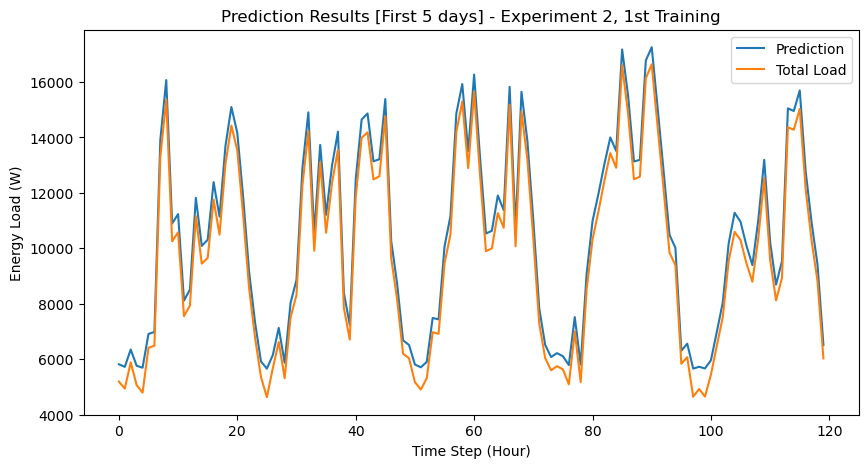

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(pp3[:120], label='Prediction')
plt.plot(fg.env.test_t.values[:120], label='Total Load')
plt.legend()
plt.xlabel('Time Step (Hour)')
plt.ylabel('Energy Load (W)')
plt.title('Prediction Results [First 5 days] - Experiment 2, 1st Training')

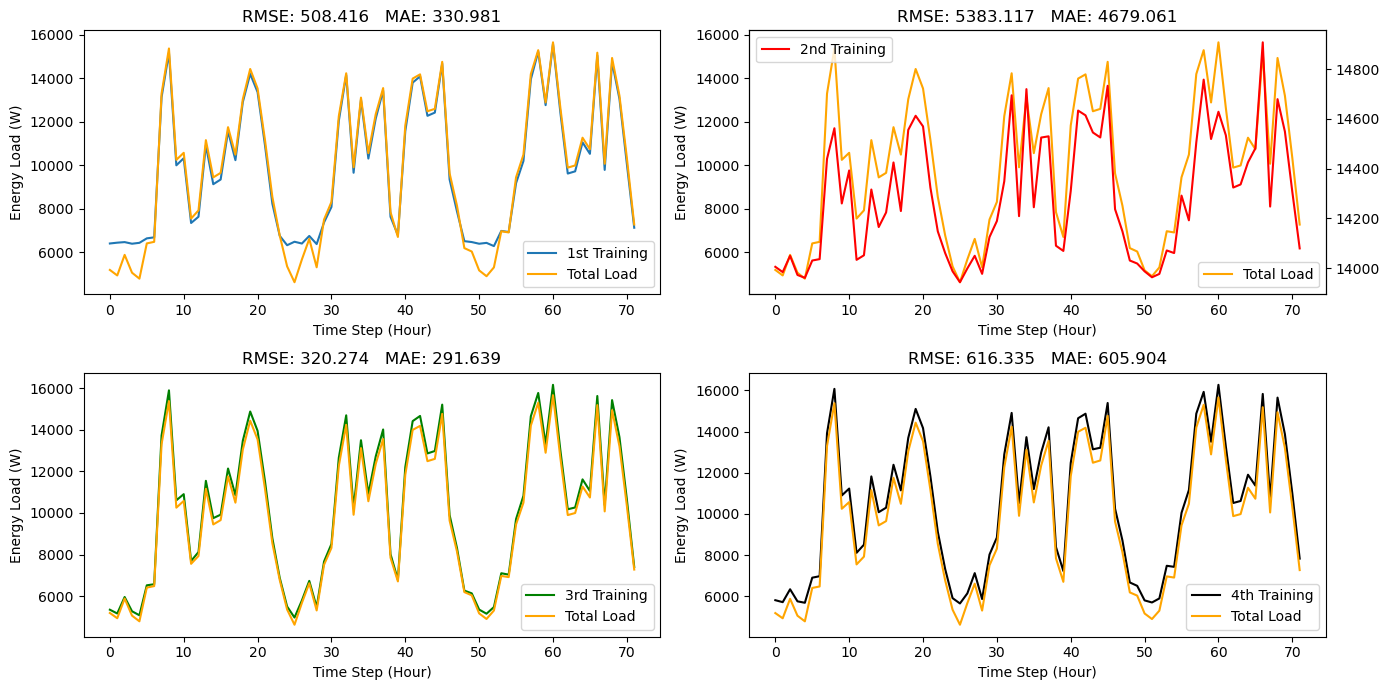

In [141]:
fig, ax = plt.subplots(2, 2, figsize=(14, 7))

#1
ax[0][0].plot(pp[:72], label='1st Training')
ax[0][0].plot(fg.env.test_t.values[:72], label='Total Load', color='orange')
ax[0][0].set_xlabel('Time Step (Hour)')
ax[0][0].set_ylabel('Energy Load (W)')
ax[0][0].legend(labels=['1st Training','Total Load'])
ax[0][0].set_title('RMSE: {0:.3f}   MAE: {1:.3f}'.format(rmse1,mae1))

#2
y = ax[0][1].twinx()
y.plot(pp1[:72], label='2nd Training', color='r')
ax[0][1].plot(fg.env.test_t.values[:72], label='Total Load', color='orange')
ax[0][1].set_xlabel('Time Step (Hour)')
ax[0][1].set_ylabel('Energy Load (W)')
ax[0][1].legend(labels=['Total Load'])
y.legend(labels=['2nd Training'])
ax[0][1].set_title('RMSE: {0:.3f}   MAE: {1:.3f}'.format(rmse2,mae2))


#3
ax[1][0].plot(pp2[:72], label='3rd Training', color='green')
ax[1][0].plot(fg.env.test_t.values[:72], label='Total Load', color='orange')
ax[1][0].set_xlabel('Time Step (Hour)')
ax[1][0].set_ylabel('Energy Load (W)')
ax[1][0].legend(labels=['3rd Training','Total Load'])
ax[1][0].set_title('RMSE: {0:.3f}   MAE: {1:.3f}'.format(rmse3,mae3))


#4
ax[1][1].plot(pp3[:72], label='4th Training', color='black')
ax[1][1].plot(fg.env.test_t.values[:72], label='Total Load', color='orange')
ax[1][1].set_xlabel('Time Step (Hour)')
ax[1][1].set_ylabel('Energy Load (W)')
ax[1][1].legend(labels=['4th Training','Total Load'])
ax[1][1].set_title('RMSE: {0:.3f}   MAE: {1:.3f}'.format(rmse4,mae4))

plt.tight_layout()

plt.legend()
plt.show()

# plt.plot(pp3[:120], label='Prediction')
# plt.plot(fg.env.test_t.values[:120], label='Total Load')
# plt.legend()
# plt.xlabel('Time Step (Hour)')
# plt.ylabel('Energy Load (W)')
# plt.title('Prediction Results [First 5 days] - Experiment 2, 1st Training')

In [131]:
type(rmse1)

numpy.float64

In [8]:
pp

[]

In [33]:
k = ForecastGame()
k.q.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [34]:
k..fit(k.env.train_x, k.env.train_y)

ValueError: in user code:

    File "C:\Users\wycon\anaconda3\envs\rlenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\wycon\anaconda3\envs\rlenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\wycon\anaconda3\envs\rlenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\wycon\anaconda3\envs\rlenv\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\wycon\anaconda3\envs\rlenv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\wycon\anaconda3\envs\rlenv\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_7" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1, 4) dtype=float32>]


In [24]:
tre=fg.env.test_y.values

In [25]:
tre

array([0.05623173, 0.04533316, 0.08598348, ..., 0.44501298, 0.34636497,
       0.28189908])

In [22]:
rst

array([0.10846173, 0.11006668, 0.1111919 , ..., 0.44047573, 0.33869565,
       0.27140954], dtype=float32)

In [16]:
rst = np.array(pp).reshape(7092)
tre = np.array(fg.env.test_y.values)

In [26]:
# rst = np.array(pp).reshape(7092)
# tre = np.array(fg.env.test_t.values)
mse1 = np.mean((rst - tre)**2)
rmse1 = np.sqrt(mse1)
mae1 = np.mean(np.abs(rst - tre))
print(rmse1,mae1)

0.0218320139571897 0.014212752885278018


In [27]:
np.mean(rst - tre)

0.0008160468012646658

In [31]:
fg.critic.model.load_weights('criticlstm0.0025.h5')
pred1 = fg.critic.model.predict(fg.env.test_x)
pp1 = []
for p in pred1:
    pp1.append(p[0])

222/222 [==============================] - 0s 1ms/step


In [32]:
fg.critic.model.load_weights('templstm0.1.h5')
pred2 = fg.critic.model.predict(fg.env.test_x)
pp2 = []
for p in pred2:
    pp2.append(p[0])

222/222 [==============================] - 0s 1ms/step


In [33]:
fg.critic.model.load_weights('criticlstm.h5')
pred3 = fg.critic.model.predict(fg.env.test_x)
pp3 = []
for p in pred3:
    pp3.append(p[0])

222/222 [==============================] - 0s 1ms/step


In [28]:
tre = fg.env.test_y.values
tre

array([0.05623173, 0.04533316, 0.08598348, ..., 0.44501298, 0.34636497,
       0.28189908])

In [98]:
pp

[array([6407.742], dtype=float32),
 array([6445.118], dtype=float32),
 array([6471.3213], dtype=float32),
 array([6396.8633], dtype=float32),
 array([6438.18], dtype=float32),
 array([6642.955], dtype=float32),
 array([6689.9683], dtype=float32),
 array([13129.5], dtype=float32),
 array([15175.406], dtype=float32),
 array([10002.064], dtype=float32),
 array([10328.264], dtype=float32),
 array([7350.083], dtype=float32),
 array([7637.8154], dtype=float32),
 array([10922.82], dtype=float32),
 array([9133.52], dtype=float32),
 array([9348.639], dtype=float32),
 array([11568.596], dtype=float32),
 array([10238.766], dtype=float32),
 array([12906.557], dtype=float32),
 array([14206.578], dtype=float32),
 array([13367.164], dtype=float32),
 array([10930.82], dtype=float32),
 array([8239.975], dtype=float32),
 array([6759.3486], dtype=float32),
 array([6328.641], dtype=float32),
 array([6487.821], dtype=float32),
 array([6405.5576], dtype=float32),
 array([6753.915], dtype=float32),
 array([6

In [29]:
rst = np.array(pp).reshape(7092)
# tre = np.array(fg.env.test_t.values)
mse1 = np.mean((rst - tre)**2)
rmse1 = np.sqrt(mse1)
mae1 = np.mean(np.abs(rst - tre))
print(rmse1,mae1)

0.0218320139571897 0.014212752885278018


In [34]:
rst2 = np.array(pp1).reshape(7092)
# tre = np.array(fg.env.test_t.values)
mse2 = np.mean((rst2 - tre)**2)
rmse2 = np.sqrt(mse2)
mae2 = np.mean(np.abs(rst2 - tre))
print(rmse2,mae2)

0.23115772958708164 0.20092469404756366


In [35]:
rst3 = np.array(pp2).reshape(7092)
# tre = np.array(fg.env.test_t.values)
mse3 = np.mean((rst3 - tre)**2)
rmse3 = np.sqrt(mse3)
mae3 = np.mean(np.abs(rst3 - tre))
print(rmse3,mae3)

0.013752936594346213 0.01252331673589768


In [36]:
rst4 = np.array(pp3).reshape(7092)
# tre = np.array(fg.env.test_t.values)
mse4 = np.mean((rst4 - tre)**2)
rmse4 = np.sqrt(mse4)
mae4 = np.mean(np.abs(rst4 - tre))
print(rmse4,mae4)

0.02646616277416408 0.026018271575770798


In [101]:
mse

258486.7465943929

In [79]:
rst

NameError: name 'rst' is not defined

In [102]:
rmse1 = np.sqrt(mse)
rmse1

508.41591890340425

In [97]:
mae = np.mean(np.abs(pp - tre))
mae

4056.2723482725582